In [24]:
import os
import sys

module_path = os.path.abspath(os.path.join('..')+'/src')
if module_path not in sys.path:
    sys.path.append(module_path)

# Ansatz

In this file, we illustrate the use of the Class ansatz.

In [172]:
import torch
from torch import nn
import warnings
import config

from math import sqrt

import matplotlib.pyplot as plt

In [173]:
import warnings
import torch
import torch as tc
from torch.func import jacfwd, vmap, grad,jacrev

class Ansatz(tc.nn.Module):
    
    def __init__(self, d, m, theta=None, kind='gaussian'):
        
        super().__init__()
        self.m = m       # model parameter 
        self.d = d       # dimension of b (same as x)
        
        # size of theta according to the the model
        if kind == 'gaussian':
            self.s = 2*m+m 
        else:
            self.s = 2*m+d*m
            warnings.warn("The type of network has not The theta parameter has not been initialized") 
        
        # Dictionary of models 
        methods = {
            'gaussian'        : self.gaussian_x,   # Eq. (16)
        }

        self.Theta = tc.rand(self.s,requires_grad=True) #if theta is None else theta
        self.theta = tc.nn.Parameter(tc.rand(self.s) if theta is None else theta)
        
        self.eval_x    = methods[kind]
        self.forward   = vmap(self.eval_x)
        
    def splitter_gaussian(self):
        c = self.theta[:self.m]
        b = self.theta[self.m: self.m+self.m*self.d ].reshape(self.m,self.d)
        w = self.theta[self.m+self.m*self.d:]
        return (c,b,w)
    
    def gaussian_x(self, x: tc.Tensor):
               
       # Input :  a SCALAR x of shape (0,)
       # Output : a SCALAR
        
        c, b, w = self.splitter_gaussian()
        return tc.sum(c*tc.exp(-w**2 *(x-b).T**2))  


    def forward(self, x):
        self.Theta = self.parameters()
        c,b,w = self.splitter_gaussian()
        #vect=lambda x: (c*tc.exp(-w**2*(x-b)**2)).sum()
        #return (c*tc.exp(-w**2*(x-b)**2)).sum()
        return tc.sum(c*tc.exp(-w**2*(x-b).T**2))
    
    def __call__(self, x):
        return self.forward(x)
        

We define the Anstazt

In [186]:
d = 1
m = 10
model = Ansatz(d,m)
x_train = torch.rand(10, 1)
print(x_train)
print(model(x_train))

tensor([[0.9863],
        [0.5789],
        [0.7244],
        [0.5533],
        [0.4904],
        [0.9912],
        [0.2210],
        [0.1022],
        [0.5651],
        [0.1460]])
tensor([4.9985, 5.2009, 5.2073, 5.1906, 5.1541, 4.9921, 4.8342, 4.6255, 5.1957,
        4.7063], grad_fn=<SumBackward1>)


In [187]:
x_domain = [0.0, 1.0]; n_points_x = 1000
mesh_x = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True).unsqueeze(1)
print(mesh_x)

print(model(mesh_x))

tensor([[0.0000],
        [0.0010],
        [0.0020],
        [0.0030],
        [0.0040],
        [0.0050],
        [0.0060],
        [0.0070],
        [0.0080],
        [0.0090],
        [0.0100],
        [0.0110],
        [0.0120],
        [0.0130],
        [0.0140],
        [0.0150],
        [0.0160],
        [0.0170],
        [0.0180],
        [0.0190],
        [0.0200],
        [0.0210],
        [0.0220],
        [0.0230],
        [0.0240],
        [0.0250],
        [0.0260],
        [0.0270],
        [0.0280],
        [0.0290],
        [0.0300],
        [0.0310],
        [0.0320],
        [0.0330],
        [0.0340],
        [0.0350],
        [0.0360],
        [0.0370],
        [0.0380],
        [0.0390],
        [0.0400],
        [0.0410],
        [0.0420],
        [0.0430],
        [0.0440],
        [0.0450],
        [0.0460],
        [0.0470],
        [0.0480],
        [0.0490],
        [0.0501],
        [0.0511],
        [0.0521],
        [0.0531],
        [0.0541],
        [0

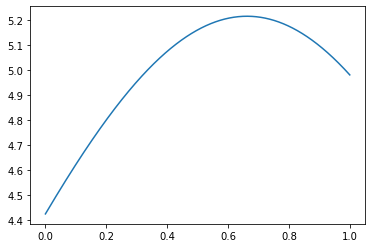

In [188]:
mesh_x.reshape(n_points_x,1).reshape(-1)

y_train = model(mesh_x)

plt.plot(mesh_x.detach(), y_train.detach())


torch.Size([1000])
torch.Size([1000])


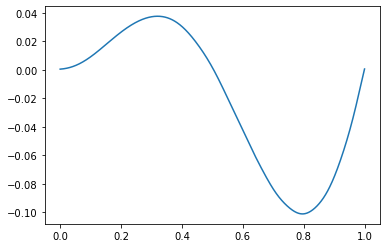

In [218]:
def u0(x):
    return (1-x) * x**2 * tc.cos(tc.pi*x)
  
y_true = u0(mesh_x).squeeze()
print(y_true.shape)
print(y_train.shape)

plt.plot(mesh_x.detach(), y_train.detach())
  
  

In [219]:
# Optimization
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

total_acc, total_loss=[], []
for epoch in range(50000):
    y_pred=model(mesh_x)
    loss = criterion(y_pred,y_true)
    if epoch%3000 == 0:
        print('epoch:',epoch,'| loss: ', loss)
    optimizer.zero_grad()
    loss.backward(retain_graph=True) # back propagation
    optimizer.step()
print(' - Training is complete')



    

loss 0 : tensor(2.7006e-06, grad_fn=<MseLossBackward0>)
loss 3000 : tensor(3.9095e-07, grad_fn=<MseLossBackward0>)
loss 6000 : tensor(1.3027e-08, grad_fn=<MseLossBackward0>)
loss 9000 : tensor(1.4856e-08, grad_fn=<MseLossBackward0>)
loss 12000 : tensor(1.3461e-08, grad_fn=<MseLossBackward0>)
loss 15000 : tensor(1.3848e-08, grad_fn=<MseLossBackward0>)
loss 18000 : tensor(1.3602e-08, grad_fn=<MseLossBackward0>)
loss 21000 : tensor(1.1344e-05, grad_fn=<MseLossBackward0>)
loss 24000 : tensor(1.0373e-06, grad_fn=<MseLossBackward0>)
loss 27000 : tensor(1.3597e-08, grad_fn=<MseLossBackward0>)
loss 30000 : tensor(1.8120e-08, grad_fn=<MseLossBackward0>)
loss 33000 : tensor(1.7897e-08, grad_fn=<MseLossBackward0>)
loss 36000 : tensor(1.6917e-08, grad_fn=<MseLossBackward0>)
loss 39000 : tensor(5.3606e-06, grad_fn=<MseLossBackward0>)
loss 42000 : tensor(2.7910e-08, grad_fn=<MseLossBackward0>)
loss 45000 : tensor(2.0627e-08, grad_fn=<MseLossBackward0>)
loss 48000 : tensor(1.5003e-08, grad_fn=<MseLos

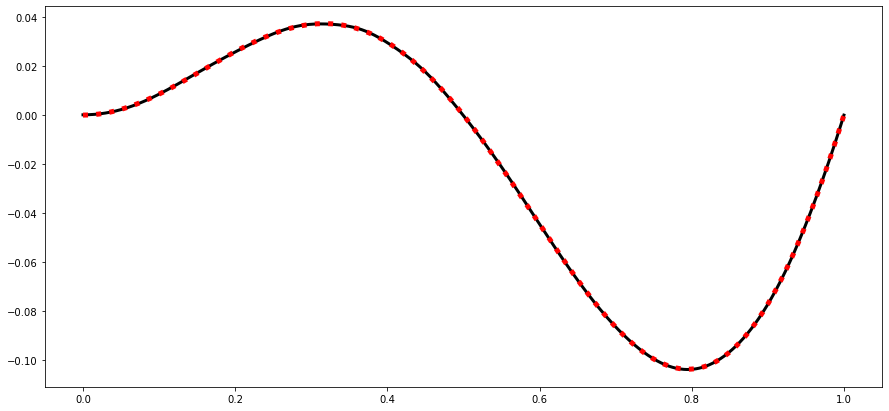

In [248]:
y_train = model(mesh_x)
fig = plt.figure(figsize=(15, 7))
plt.plot(mesh_x.detach(), y_train.detach(), 'k', lw=3)
plt.plot(mesh_x.detach(), y_true.detach(),'r:', lw=5)